
1. **Upcycling a Dense Model into an MoE 🔄 🚴
2. **Continued Pretraining 📚💪**
3. **Expert specialization 🧙 ✨**


## **custom Smol`MoE`LM 🔍🐛**

### 1. Setup [Helper Functions]

In [ ]:
# # Download the weights from HF
from huggingface_hub import hf_hub_download
path = hf_hub_download(repo_id="dsouzadaniel/C4AI_SmolMoELM",
                       filename="trial_weights.pt",
                      local_dir=".",)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


trial_weights.pt:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [ ]:
# Libraries
import time
import math
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer


def timed(fn):
    '''Simple Timing Decorator'''
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        out = fn(*args, **kwargs)
        total_time = time.perf_counter() - start_time
        print(f"time={total_time:.3f}s")
        return out
    return wrapper

def labelthis(label):
    '''Simple Label Assigner'''
    def deco(fn):
        fn.label = label
        return fn
    return deco

def pretty_dt(s: float) -> str:
    '''Print Time Taken(but pretty :) )'''
    if s < 1e-6: return f"{s*1e9:.0f} ns"
    if s < 1e-3: return f"{s*1e6:.0f} µs"
    if s < 1:    return f"{s*1e3:.0f} ms"
    if s < 60:   return f"{s:.3f} s"
    h, s = divmod(s, 3600); m, s = divmod(s, 60)
    return (f"{int(m)}m {int(s)}s" if h < 1 else f"{int(h)}h {int(m)}m {int(s)}s")

@timed
def __generate(model, tokenizer, inputs, num_tokens):
    '''Helper function. Recommended to use via `generation_compare`'''
    collect = []
    for _ in range(num_tokens):
        output = model(**inputs)
        output_id = torch.argmax(output['logits'][0,-1]).item()
        collect.append(output_id)
        if output_id==tokenizer.eos_token_id:
            break
        inputs['input_ids'] = torch.unsqueeze(torch.cat([inputs['input_ids'][0],torch.tensor([output_id])]),dim=0)
        inputs['attention_mask'] = torch.ones_like(inputs['input_ids'])
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(collect))

def generation_compare(prompt, num_tokens, tokenizer, model_A, model_B=None):
    '''Compares generations of two models. Passing just one model provides simple generation utility'''
    print()
    print(f"{'>'*20}\n\tPrompt\n{'<'*20}\n{prompt}\n\n")
    model_inputs = tokenizer(prompt, return_tensors='pt')
    print(f"{'>'*30}\n\tModel_A Generation\n{'<'*30}\n{__generate(model_A,  tokenizer, model_inputs, num_tokens)}")
    print("\n\n")
    if model_B:
        model_inputs = tokenizer(prompt, return_tensors='pt')
        print(f"{'>'*30}\n\tModel_B Generation\n{'<'*30}\n{__generate(model_B,  tokenizer, model_inputs, num_tokens)}")

def detach_metrics(metrics: dict):
    '''helper for metrics'''
    def to_cpu(x):
        if isinstance(x, torch.Tensor):
            # If scalar, return float; if vector/matrix, return list
            return x.detach().cpu().item() if x.dim() == 0 else x.detach().cpu().tolist()
        elif isinstance(x, list):
            return [to_cpu(y) for y in x]
        elif isinstance(x, dict):
            return {k: to_cpu(v) for k, v in x.items()}
        return x

    return {k: to_cpu(v) for k, v in metrics.items()}

def plot_metrics(metrics: dict, x_vals=None, suptitle="Training Metrics"):
    '''For grid plotting a collection of metrics'''
    metrics = detach_metrics(metrics)

    keys = list(metrics.keys())
    n = len(keys)
    length = len(next(iter(metrics.values())))
    if not x_vals:
        x_vals = list(range(1,length + 1))

    fig, axes = plt.subplots(1, n, figsize=(4*n, 3), constrained_layout=True)
    if n == 1:
        axes = [axes]

    palette = plt.cm.tab10.colors

    for i, (ax, key_str) in enumerate(zip(axes, keys)):
        y_vals = metrics[key_str]
        ax.plot(x_vals, y_vals, marker="o", color=palette[i % len(palette)])
        ax.set_title(key_str)
        ax.grid(True, alpha=0.3)

    fig.suptitle(suptitle)
    fig.supxlabel("Steps")
    plt.show()


class smolMoEConfig:
    vocab_size=49152
    hidden_size=576
    intermediate_size=1536
    num_hidden_layers = 30
    num_heads=9
    kv_heads=3
    num_experts = 3
    num_experts_per_tok = 1

config = smolMoEConfig

TEST_PROMPT = "Where is the Great Wall?"


### 2. Custom Smol`MoE`LM (for BugFixes)

In [ ]:
def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    if cos.device != q.device:
        cos = cos.to(q.device)
        sin = sin.to(q.device)
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

def repeat_kv(hidden_states, n_rep):
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

class RotaryEmbedder(nn.Module):
    def __init__(self, dim, base):
        super().__init__()
        self.freq = 1/(base ** (torch.arange(0, dim, 2, dtype=torch.int64).float()/dim))

    @torch.no_grad()
    def forward(self,x):
        pos = torch.arange(x.shape[-2],dtype=torch.long)
        angles = torch.einsum('f,p->pf', self.freq, pos.float()).unsqueeze(dim=0)

        emb = torch.cat((angles, angles), dim=-1)
        return emb.cos(), emb.sin()

class MoE(nn.Module):
    """
    An MoE layer with MLP block with swiglue activation function.
    """

    def __init__(self, num_experts_per_tok: int, num_experts: int, emb_dim: int, moe_dim: int, dtype=torch.float32):
        super().__init__()
        self.k = int(num_experts_per_tok)
        self.E = int(num_experts)
        self.D = int(emb_dim)
        self.H = int(moe_dim)

        self.gate = nn.Linear(self.D, self.E, bias=False, dtype=dtype)

        self.gate_bank = nn.Parameter(torch.empty(self.E, self.D, self.H, dtype=dtype))
        self.up_bank   = nn.Parameter(torch.empty(self.E, self.D, self.H, dtype=dtype))
        self.down_bank = nn.Parameter(torch.empty(self.E, self.H, self.D, dtype=dtype))

    def expert_utilization(self, logits):
        """
        This function compute expert utilization per layer and also compute load balancer loss.
        Details of this load balancer can be found in https://arxiv.org/abs/2101.03961
        """
        selected = torch.argmax(logits, dim=-1)
        selected = F.one_hot(selected, num_classes=self.E)

        load = torch.mean(selected.float(), dim=(0,1))

        importance = torch.mean(F.softmax(logits, dim=-1), dim=(0,1))
        self._aux_lb = self.E * torch.sum(load * importance)

        self._expert_utilization = selected

    def forward(self, x):
        B, T, D = x.shape
        assert D == self.D, f"Expected emb_dim={self.D}, got {D}"
        logits = self.gate(x)

        if self.training:
            logits = logits + torch.randn_like(logits) * 1e-1

        selected = torch.argmax(logits, dim=-1)

        a = torch.einsum("btd,edh->bteh", x, self.gate_bank)
        u = torch.einsum("btd,edh->bteh", x, self.up_bank)

        h = F.silu(a) * u

        y = torch.einsum("bteh,ehd->bted", h, self.down_bank)

        gather_idx = selected.view(B,T,1,1).expand(-1, -1, -1, D)
        y = torch.gather(y, dim=2, index=gather_idx).squeeze(-2)

        self.expert_utilization(logits)
        return y


class RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states


class RopeAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.hidden_size=config.hidden_size
        self.num_heads = config.num_heads
        self.head_dim = config.hidden_size//self.num_heads
        self.kv_heads = config.kv_heads
        self.rope_theta = 10000.0

        self.W_query = nn.Linear(config.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.W_key = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.W_value = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.W_output = nn.Linear(config.hidden_size, config.hidden_size, bias=False)
        self.rotary_emb = RotaryEmbedder(base=self.rope_theta,
                                         dim=config.hidden_size//self.num_heads)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask= None,
    ):
        b, q, _ = hidden_states.size()

        q_states = self.W_query(hidden_states)
        k_states = self.W_key(hidden_states)
        v_states = self.W_value(hidden_states)

        q_states = q_states.view(b, q, self.num_heads, self.head_dim).transpose(1, 2)
        k_states = k_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)
        v_states = v_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)

        cos, sin = self.rotary_emb(v_states)
        q_states, k_states = apply_rotary_pos_emb(q_states, k_states, cos, sin)

        __kv_groups = self.num_heads // self.kv_heads

        k_states = repeat_kv(k_states, __kv_groups)
        v_states = repeat_kv(v_states, __kv_groups)

        attn_weights = torch.matmul(q_states, k_states.transpose(2, 3)) / math.sqrt(self.head_dim)
        attn_weights = attn_weights + attention_mask
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        attn_weights = nn.functional.dropout(attn_weights,p=0)


        attn_output = torch.matmul(attn_weights, v_states)
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(b, q, -1)

        attn_output = self.W_output(attn_output)

        return attn_output

class LlamaDecoder(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.self_attn = RopeAttention(config)
        self.moe = MoE(num_experts=config.num_experts,
                       num_experts_per_tok=config.num_experts_per_tok,
                       emb_dim=config.hidden_size,
                       moe_dim=config.intermediate_size)
        self.pre_attn_rmsnorm = RMSNorm(config.hidden_size, eps=1e-05)
        self.pre_moe_rmsnorm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self,hidden_states, attention_mask):
        residual = hidden_states
        hidden_states = self.pre_attn_rmsnorm(hidden_states)
        attention_mask = torch.triu(torch.full((attention_mask.shape[-1],attention_mask.shape[-1]), fill_value=float('-inf'), device = hidden_states.device),diagonal=1)

        hidden_states = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
        )
        hidden_states += residual
        residual = hidden_states

        hidden_states = self.pre_moe_rmsnorm(hidden_states)
        hidden_states = self.moe(hidden_states)
        hidden_states += residual

        outputs = (hidden_states,)

        return outputs

class smolMoEModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(num_embeddings=config.vocab_size,
                                         embedding_dim=config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoder(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(
        self,
        input_ids= None,
        attention_mask= None,
    ):
        inputs_embeds = self.embed_tokens(input_ids)
        hidden_states = inputs_embeds
        for decoder_layer in self.layers:
            layer_outputs = decoder_layer(
                hidden_states,
                attention_mask=attention_mask,
            )
            hidden_states = layer_outputs[0]
        hidden_states = self.norm(hidden_states)
        return [hidden_states]

class smolMoELM(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.model = smolMoEModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

    def forward(self,input_ids,attention_mask):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        hidden_states = outputs[0]

        logits = self.lm_head(hidden_states)
        logits = logits.float()
        return {'logits':logits}

    def get_expert_utilization(self):
        lb_vals, utils = [], []

        for layer in self.model.layers:
            moe = layer.moe
            if hasattr(moe, "_aux_lb"):
                lb_vals.append(moe._aux_lb)
            if hasattr(moe, "_expert_utilization"):
                utils.append(moe._expert_utilization)
        if lb_vals:
            lb_loss = torch.stack([v if v.dim() == 0 else v.squeeze() for v in lb_vals]).mean()
        else:
            lb_loss = torch.tensor(0.0, device=next(self.parameters()).device)
        return utils, lb_loss

    def reset_weights_and_metrics(self):
        with torch.no_grad():
            modules = list(self.modules())[1:]
            for m in modules:
                fn = getattr(m, "reset_parameters_", None) or getattr(m, "reset_parameters", None)
                if callable(fn):
                    fn()

            for m in modules:
                if hasattr(m, "reset_parameters") or hasattr(m, "reset_parameters_"):
                    continue
                any_param = False
                for name, p in m.named_parameters(recurse=False):
                    any_param = True
                    if p.dim() == 1:
                        if name == "bias":
                            p.zero_()
                        else:
                            p.fill_(1.0)
                    else:
                        nn.init.kaiming_uniform_(p, a=math.sqrt(5))

### 3. Test

In [ ]:
# Load the Tokenizer
checkpoint="HuggingFaceTB/SmolLM-135M"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

########################
#### SANITY CHECK ######
########################

# # Instantiate the model
# __test_model = smolMoELM(config)

# #💡 You expect a nonsensical/garbled output here since the weights are random
# generation_compare(
#     prompt=TEST_PROMPT,
#     tokenizer=tokenizer,
#     num_tokens=50,
#     model_A= __test_model,
# )

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

In [ ]:
########################
###### CHECK #1 ########
########################

# Instantiate the model
__test_model = smolMoELM(config)

# Load the weights into your implementation
__test_model.load_state_dict(torch.load('trial_weights.pt'), strict=True)


generation_compare(
    prompt=TEST_PROMPT,
    tokenizer=tokenizer,
    num_tokens=50,
    model_A= __test_model,
    model_B=None
)


>>>>>>>>>>>>>>>>>>>>
	Prompt
<<<<<<<<<<<<<<<<<<<<
Where is the Great Wall?


time=28.334s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_A Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


The Great Wall of China is a 13,000-mile-long wall that spans 1, lay of the country. It is located in the northern part of China, stretching from the border with Mongolia to the border





In [ ]:
########################
###### CHECK #2 ########
########################


correct_lb_loss = torch.tensor(1.0)
_, lb_loss = __test_model.get_expert_utilization()
print(f"(Expected) Load Balance Loss => {correct_lb_loss:0.2f}")
print(f"(Actual) Load Balance Loss => {lb_loss:0.2f}")
assert torch.isclose(lb_loss, correct_lb_loss, atol=1e-2), "Load Balance Check don't match!"

######################################################################################################################
############################################### DO NOT CHANGE[END] ###################################################
######################################################################################################################

(Expected) Load Balance Loss => 1.00
(Actual) Load Balance Loss => 1.00


# **Coding Challenge Part 2: Upcycling a Dense Model into an MoE 🔄 🚴 [🚨 3 points]**


Now that we have worked through an implementation of the MoE architecture, lets look at a procedure called "Upcycling" wherein you convert a dense model into an MoE.

**Guidelines** :

You will upcycle the dense model loaded below into our MoE implementation from Part 1. No changes are required of the MoE implementation for this part.


**🚨 Reference paper:** [Sparse Upcycling: Training Mixture-of-Experts from Dense Checkpoints](https://arxiv.org/abs/2212.05055)

> *This paper introduces a method to transform pre-trained dense models into Mixture-of-Experts (MoE) models, leveraging existing weights instead of training from scratch. This "upcycling" approach selectively sparsifies the model into expert modules, enabling more efficient scaling and training while reducing computational costs. Experiments show that these upcycled MoEs can outperform both standard dense models and traditionally trained MoEs, demonstrating that dense checkpoints contain useful knowledge that can be repurposed for sparse architectures.*



### 1. Setup

In [ ]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################


# Loading the Dense Model
dense_model = AutoModelForCausalLM.from_pretrained(checkpoint)

# Resetting the weights for a clean upcycle!
__test_model.reset_weights_and_metrics()

#💡 This is expected to be garbled due to resetting weights before upcycling.
generation_compare(
    prompt=TEST_PROMPT,
    tokenizer=tokenizer,
    num_tokens=50,
    model_A= dense_model,
    model_B=__test_model
)

######################################################################################################################
############################################### DO NOT CHANGE[END] ###################################################
######################################################################################################################

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]


>>>>>>>>>>>>>>>>>>>>
	Prompt
<<<<<<<<<<<<<<<<<<<<
Where is the Great Wall?


time=31.832s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_A Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

The Great Wall of China is the longest wall in the world. It stretches over 13,000 miles and is 13,000 feet high. It is located in the northern part of China, in the country



time=35.437s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_B Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kidsesses associate Spiritcoding unfortunate severity reliant Lithuan severity Norton broughtplementary�ovie�<reponame> rarelycontrollersakinHandlerperiodBlock perenn Warsaw rewarding Notice]* stunted factors parliament Acknowledge TunisiaBranch flat juices escap dock acres fieldwork Swahili parliamentcontrollersakincomplete Many Hippiba Spectcu


### 2. Upcycling (for Implementation)

In [ ]:
######################################################################
##################### Write "Upcycling" code here ####################
######################################################################


def upcycle_dense_to_moe(dense_model, moe_model):
    """
    Upcycles a dense model to the smolMoEModel.
    """
    # 1. Token Embeddings and Final LM Head
    moe_model.model.embed_tokens.weight.data = dense_model.model.embed_tokens.weight.data.clone()
    moe_model.lm_head.weight.data = dense_model.lm_head.weight.data.clone()

    # 2. Final RMSNorm
    moe_model.model.norm.weight.data = dense_model.model.norm.weight.data.clone()

    # 3. Transformer Blocks
    for i, dense_layer in enumerate(dense_model.model.layers):
        moe_layer = moe_model.model.layers[i]

        # a. Attention Layers
        moe_layer.self_attn.W_query.weight.data = dense_layer.self_attn.q_proj.weight.data.clone()
        moe_layer.self_attn.W_key.weight.data = dense_layer.self_attn.k_proj.weight.data.clone()
        moe_layer.self_attn.W_value.weight.data = dense_layer.self_attn.v_proj.weight.data.clone()
        moe_layer.self_attn.W_output.weight.data = dense_layer.self_attn.o_proj.weight.data.clone()

        # b. Pre-Attention RMSNorm
        moe_layer.pre_attn_rmsnorm.weight.data = dense_layer.input_layernorm.weight.data.clone()

        # c. Pre-MoE RMSNorm
        moe_layer.pre_moe_rmsnorm.weight.data = dense_layer.post_attention_layernorm.weight.data.clone()

        # d. FFN -> MoE Experts (The Core Upcycling Step for SwiGLU)
        dense_ffn_gate = dense_layer.mlp.gate_proj.weight.data.clone().T
        dense_ffn_up = dense_layer.mlp.up_proj.weight.data.clone().T
        dense_ffn_down = dense_layer.mlp.down_proj.weight.data.clone().T

        # Replicate the dense FFN weights for each expert
        moe_layer.moe.gate_bank.data.copy_(dense_ffn_gate.unsqueeze(0).expand_as(moe_layer.moe.gate_bank))
        moe_layer.moe.up_bank.data.copy_(dense_ffn_up.unsqueeze(0).expand_as(moe_layer.moe.up_bank))
        moe_layer.moe.down_bank.data.copy_(dense_ffn_down.unsqueeze(0).expand_as(moe_layer.moe.down_bank))

        # e. Initialize Router (Gate) weights to small random values
        nn.init.kaiming_uniform_(moe_layer.moe.gate.weight, a=math.sqrt(5))

    print("\nUpcycling complete!")


upcycle_dense_to_moe(dense_model, __test_model)



Upcycling complete!


In [ ]:
# Quick sanity check: the two models should produce very similar logits
ids = tokenizer(TEST_PROMPT, return_tensors="pt").input_ids.to(next(__test_model.parameters()).device)
amask = torch.ones_like(ids)

with torch.no_grad():
    a = dense_model(input_ids=ids, attention_mask=amask).logits
    b = __test_model(input_ids=ids, attention_mask=amask)['logits']
    max_err = (a - b).abs().max().item()
print(f"Max |Δlogit|: {max_err:.12f}")

Max |Δlogit|: 0.000031471252


### 3. Test

In [ ]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################


#💡 If you upcycled correctly, you will output the exact same generation as the dense model!
generation_compare(
    prompt=TEST_PROMPT,
    tokenizer=tokenizer,
    num_tokens=50,
    model_A= dense_model,
    model_B=__test_model
)


######################################################################################################################
############################################### DO NOT CHANGE[END] ###################################################
######################################################################################################################


>>>>>>>>>>>>>>>>>>>>
	Prompt
<<<<<<<<<<<<<<<<<<<<
Where is the Great Wall?


time=12.319s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_A Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

The Great Wall of China is the longest wall in the world. It stretches over 13,000 miles and is 13,000 feet high. It is located in the northern part of China, in the country



time=28.484s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_B Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

The Great Wall of China is the longest wall in the world. It stretches over 13,000 miles and is 13,000 feet high. It is located in the northern part of China, in the country


# **Continued Pretraining 📚💪**

**Note** :
*   For this section, make sure that the model you are using is still the same `__test_model` you upcycled in the previous section.
*   We recommend using a GPU for this section. We have provided the below settings and ensure that they run on the free T4 GPUs on Colab. Make sure you manage your free GPU usage wisely :)


Now that we have an upcycled MoE, lets continue pretraining on a small subset of data to train the expert router.

You will be required to :
* 1. Write a simple training loop (*and implement functions related to this*)
* 2. **Propose a MoE-specific metric** to track whether the MoE is actually learning as expected, implement it and provide a 2 line description of your metric in the space provided.

### 1. Setup

In [ ]:
STEPS = 100
REPORT_AFTER_N_STEPS = 10
BATCH_SIZE = 4
BF16 = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
__test_model.to(device) ### Note: This should be the upcycled model as a result of completing Part 2.
print(f"Using Device : {device}")

scaler_enabled = (device=="cuda" and BF16)
autocast_dtype = torch.bfloat16 if scaler_enabled else None

def build_dataset(
    dataset_id,
    subset,
    split,
    tokenizer,
    block_size,
    max_samples=1000,
    text_column="text",
    val_fraction=None,
    seed=42,
):
    ds = load_dataset(dataset_id, subset, split=split) if subset else load_dataset(dataset_id, split=split)
    ds = ds.select(range(max_samples))

    EOS = tokenizer.eos_token_id
    def tok(batch):
        out = tokenizer(batch[text_column],
                        add_special_tokens=False,
                        return_attention_mask=True)
        out["input_ids"]      = [ids + [EOS] for ids in out["input_ids"]]
        out["attention_mask"] = [m   + [1]   for m   in out["attention_mask"]]
        return {"input_ids": out["input_ids"], "attention_mask": out["attention_mask"]}

    ds = ds.map(tok, batched=True,remove_columns=[c for c in ds.column_names if c not in ("input_ids", "attention_mask")])

    def group_per_doc(batch):
        out_ids = []
        for ids in batch["input_ids"]:
            L = len(ids)
            n = (L // block_size) * block_size
            for i in range(0, n, block_size):
                out_ids.append(ids[i:i+block_size])
        return {"input_ids": out_ids, "attention_mask": [[1]*len(o) for o in out_ids]}

    ds = ds.map(group_per_doc, batched=True)

    if val_fraction and 0.0 < val_fraction < 1.0:
        ds = ds.train_test_split(test_size=val_fraction, seed=seed, shuffle=True)
        train_ds, val_ds = ds["train"], ds["test"]
        train_ds.set_format(type="torch", columns=["input_ids","attention_mask"])
        val_ds.set_format(type="torch", columns=["input_ids","attention_mask"])
        return train_ds, val_ds

    ds.set_format(type="torch", columns=["input_ids","attention_mask"])
    return ds


train_ds, val_ds = build_dataset(dataset_id="HuggingFaceTB/cosmopedia-100k",
                                 subset=None,
                                 split="train",
                                 tokenizer=tokenizer,
                                 block_size=256, # This is intentionally small number DO NOT change this number.
                                 val_fraction=0.2,   # 20% as validation
                                 max_samples=1000, # This only picks first 1000 examples from the dataset. Do NOT change this number.
                                 seed=789)

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=(device=="cuda")
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, pin_memory=(device=="cuda")
)


print(f"Train Dataset Batches : {len(train_loader)}")
print(f"Validation Dataset Batches : {len(val_loader)}")


NameError: name 'torch' is not defined

### 2. Continued Pretraining (for Implementation)

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import GradScaler, autocast

from datetime import timedelta
import itertools

In [ ]:
LEARNING_RATE = 3e-5
LB_LOSS_COEF = 0.01 # Coefficient for the load balancing auxiliary loss



opt = AdamW(__test_model.parameters(), lr=LEARNING_RATE)
scheduler = CosineAnnealingLR(opt, T_max=STEPS, eta_min=LEARNING_RATE/10)
scaler = GradScaler("cuda", enabled=scaler_enabled)

#### Helper Functions :
* *causal_lm_loss*(🚨 1 point)
*  *eval_loss* (🚨 1 point)
*  *custom_moe_metric* (🚨 2 points)

In [ ]:
############################################
############## HELPER FNS ##################
############################################

def causal_lm_loss(logits, labels):
    """
    Calculates the cross-entropy loss for causal language modeling.
    The prediction for token i is compared against the actual token i+1.
    """
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return loss

@torch.no_grad()
def evaluate_loss(model, loader, device):
    """
    Evaluates the model on a given data loader.
    """
    model.eval()
    total_loss = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        with autocast(device_type="cuda", dtype=autocast_dtype, enabled=scaler_enabled):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = causal_lm_loss(outputs['logits'], input_ids)

        total_loss += loss.item()

    model.train()

    return total_loss / len(loader)

@labelthis('Active Expert Percentage')
@torch.no_grad()
def custom_moe_metric(model, loader=val_loader, device=device):
    """
    Calculates the percentage of experts that are active (used for at least one token).
    """
    model.eval()

    batch = next(iter(loader))
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    _ = model(input_ids=input_ids, attention_mask=attention_mask)
    expert_utilizations, _ = model.get_expert_utilization()

    if not expert_utilizations:
        model.train()
        return 0.0

    all_utils = torch.stack(expert_utilizations)
    tokens_per_expert = all_utils.sum(dim=(1, 2))
    active_experts = torch.sum(tokens_per_expert > 0).item()
    total_experts = tokens_per_expert.numel()

    model.train()
    return (active_experts / total_experts) * 100.0


####  Training loop (🚨 2 points)

In [ ]:
######################################################################
############### Write "Continued Pretraining" code here ##############
######################################################################

train_iter = itertools.cycle(train_loader)

moe_metric = custom_moe_metric(__test_model)
print(f"[Before Training : Sanity Check] {custom_moe_metric.label}: {moe_metric:.1f}%\n")

t0 = time.time()

training_metrics = {'Train Loss': [], 'Eval Loss': [], 'Load Balancing Loss': []}
moe_metrics = {custom_moe_metric.label: []}

__test_model.train()

cumulative_train_loss = 0.0
cumulative_lb_loss = 0.0

for step in range(1, STEPS+1):
    batch = next(train_iter)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    with autocast(device_type="cuda", dtype=autocast_dtype, enabled=scaler_enabled):
        outputs = __test_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs['logits']

        lm_loss = causal_lm_loss(logits, input_ids)
        _, lb_loss = __test_model.get_expert_utilization()

        total_loss = lm_loss + LB_LOSS_COEF * lb_loss


    scaler.scale(total_loss).backward()
    torch.nn.utils.clip_grad_norm_(__test_model.parameters(), 1.0)

    scaler.step(opt)
    scaler.update()
    opt.zero_grad(set_to_none=True)
    scheduler.step()

    cumulative_train_loss += lm_loss.item()
    cumulative_lb_loss += lb_loss.item()

   #########################################################
   ############## Eval/Reporting Section ###################
   #########################################################
    if step % REPORT_AFTER_N_STEPS == 0:

        # Calculate average losses for reporting
        avg_train_loss = cumulative_train_loss / REPORT_AFTER_N_STEPS
        avg_lb_loss = cumulative_lb_loss / REPORT_AFTER_N_STEPS

        val_loss = evaluate_loss(__test_model, val_loader, device)

        training_metrics['Train Loss'].append(avg_train_loss)
        training_metrics['Eval Loss'].append(val_loss)
        training_metrics['Load Balancing Loss'].append(avg_lb_loss)

        moe_metric = custom_moe_metric(__test_model)
        moe_metrics[custom_moe_metric.label].append(moe_metric)

        time_taken= (time.time()-t0)
        # KEEP THE SAME FORMATTING
        print(f"Step {step}/{STEPS} | Train Loss: {avg_train_loss:.3f} | Eval Loss: {val_loss:.3f} | LB Loss: {avg_lb_loss:.3f} | Time Taken: {pretty_dt(time_taken)}")
        print("***"*30)

        cumulative_train_loss = 0.0
        cumulative_lb_loss = 0.0
        t0 = time.time()

   ###################################################
   ############## Training Section ###################
   ###################################################



[Before Training : Sanity Check] Active Expert Percentage: 100.0%

Step 10/100 | Train Loss: 2.148 | Eval Loss: 2.117 | LB Loss: 1.012 | Time Taken: 34.828 s
******************************************************************************************
Step 20/100 | Train Loss: 2.244 | Eval Loss: 2.112 | LB Loss: 1.011 | Time Taken: 30.821 s
******************************************************************************************
Step 30/100 | Train Loss: 2.048 | Eval Loss: 2.109 | LB Loss: 1.010 | Time Taken: 31.975 s
******************************************************************************************
Step 40/100 | Train Loss: 2.086 | Eval Loss: 2.108 | LB Loss: 1.009 | Time Taken: 31.457 s
******************************************************************************************
Step 50/100 | Train Loss: 2.153 | Eval Loss: 2.106 | LB Loss: 1.009 | Time Taken: 31.405 s
******************************************************************************************
Step 60/100 | Train Los

### 3. Test

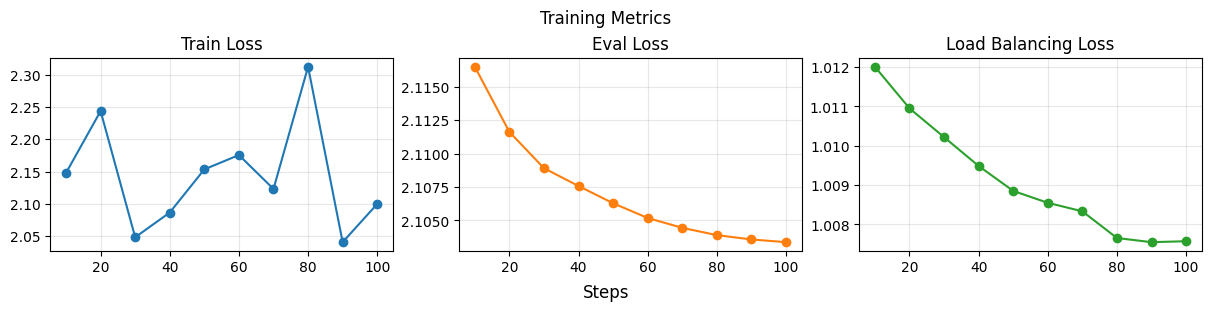

In [ ]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################

# Verify plots
x_vals = [REPORT_AFTER_N_STEPS * i for i in range(1, len(training_metrics['Train Loss'])+1)]
plot_metrics(training_metrics, x_vals=x_vals, suptitle="Training Metrics")

######################################################################################################################
############################################## DO NOT CHANGE[END] ##################################################
######################################################################################################################

#### Plot MoE Metric with Explanation(🚨 1 points)

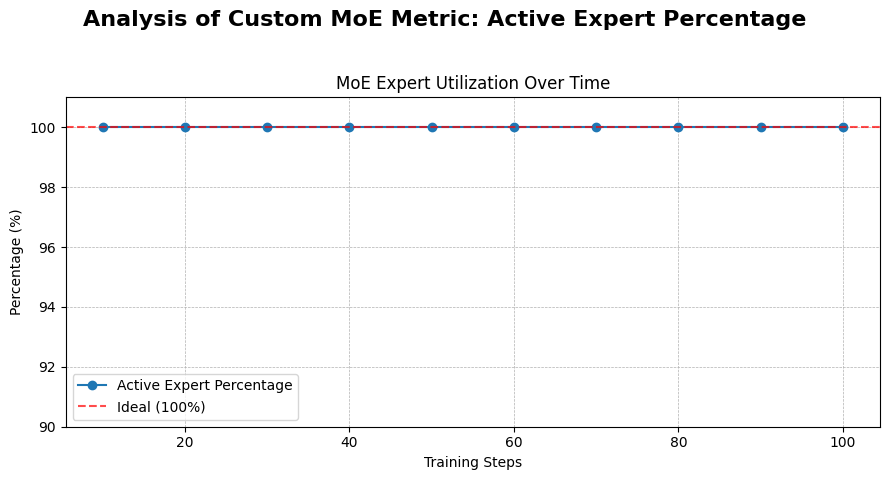

In [ ]:
######################################################################################################################
############################################## PLOT YOUR CUSTOM MOE METRICS ##################################################
######################################################################################################################

def plot_custom_metric(metrics: dict, suptitle=None):
    """
    Plots the custom MoE metrics recorded during training.
    """
    fig, ax = plt.subplots(figsize=(9, 5))

    try:
        num_data_points = len(next(iter(metrics.values())))
        x_axis_values = np.arange(1, num_data_points + 1) * REPORT_AFTER_N_STEPS
    except (StopIteration, NameError):
        x_axis_values = np.arange(len(next(iter(metrics.values()))))

    for metric_name, values in metrics.items():
        ax.plot(x_axis_values, values, marker='o', linestyle='-', label=metric_name)
        ax.axhline(y=100, color='r', linestyle='--', label='Ideal (100%)', alpha=0.7)

    ax.set_title("MoE Expert Utilization Over Time")
    ax.set_xlabel("Training Steps")
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(bottom=min(90, min(values)-2) if values else 90, top=101)

    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    if suptitle:
        fig.suptitle(suptitle, fontsize=16, weight='bold')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_custom_metric(moe_metrics, suptitle="Analysis of Custom MoE Metric: Active Expert Percentage")

### Why I chose `Active Expert Percentage`

I chose this metric because it directly reflects how effectively the routing mechanism engages the available experts. A low value indicates the presence of *dead experts* that never receive tokens, signaling that the model is under-utilizing capacity and not benefiting from the diversity of its expert pool. By tracking this metric, I can assess whether training encourages balanced expert usage, which is essential for improving both efficiency and specialization in MoE models.



In [ ]:
######################################################################################################################
############################################## DO NOT CHANGE[START] ##################################################
######################################################################################################################

#💡 Verify that the model didn't collapse and can still generate coherent text.
#   You dont expect this to be the same as the dense model, but should still be coherent
__test_model.to('cpu')
__test_model.eval()

generation_compare(
    prompt=TEST_PROMPT,
    tokenizer=tokenizer,
    num_tokens=50,
    model_A= dense_model,
    model_B=__test_model
)

######################################################################################################################
############################################### DO NOT CHANGE[END] ###################################################
######################################################################################################################


>>>>>>>>>>>>>>>>>>>>
	Prompt
<<<<<<<<<<<<<<<<<<<<
Where is the Great Wall?


time=12.622s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_A Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

The Great Wall of China is the longest wall in the world. It stretches over 13,000 miles and is 13,000 feet high. It is located in the northern part of China, in the country



time=28.535s
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
	Model_B Generation
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

The Great Wall of China is a massive wall that stretches over 13,000 miles from the city of Beijing in the north to the city of Shanxi in the south. It is the longest wall in the world and is considered


# **Coding Challenge Part 4:  Exploring The Unknown 🧙 ✨ **

In this part, you can choose any one of the provided questions below.

Both questions are open-ended, and there is no one single solution -- you can follow any paper you find related to the question you picked and also you can be fully creative.

We want to see how you will approach the problem and how you will show that your approach is working.    

1. **Make training more efficient with dataset intervention:** Now you can process the whole dataset ([cosmopedia-100k](https://huggingface.co/datasets/HuggingFaceTB/cosmopedia-100k), but you can only sample the same number of examples (1000). How would you modify/filter the original dataset for making the training more efficient?

2. **Explore methods to increase expert specilization for given datasets:** You are given these 3 datasets inside [Nemotron-Post-Training-Dataset (SFT partition)](https://huggingface.co/datasets/nvidia/Llama-Nemotron-Post-Training-Dataset): [chat, math and code subsets](https://huggingface.co/datasets/nvidia/Llama-Nemotron-Post-Training-Dataset#filtering-the-data); develop training methods/pipelines that increase expert specialization for each data. (Each expert will focus on one of these datasets rathen than distributing uniformly.)

**NOTE:** If your MoE implementation does not work, you can pick the 1 question and show the effectiness of your method on dense model training.


# Table of Content

>[Inducing Expert Specialization](#scrollTo=J_B8HLVIa2eJ)

>>[Notebook Setup and Imports](#scrollTo=RWIFC7NAjzKs)

>>[Model Architecture Definitions](#scrollTo=W6ZExcKni1aF)

>>[Model Initialization and Configuration](#scrollTo=RlTGjbB2kD-N)

>>[Specialization Loss Function](#scrollTo=m25244P_kO1E)

>>[Data Preparation for Specialized Training](#scrollTo=Ii0Q8IkdkYe4)

>>[Training](#scrollTo=pArdJL2-lGL_)

>>[Routing Analysis (Result)](#scrollTo=fbIQh6xKlvwb)

>>[Training for even longer](#scrollTo=wsfUU9Qr52ei)



# **Inducing Expert Specialization**
>>[SKIP TO RESULTS SECTION](#scrollTo=fbIQh6xKlvwb)

My solution to this problem consist of 4 key components:

**1. Architectural Modifications for Analysis and Control**

First, I modified the model architecture to enable guided training and analysis.
*   Each decoder layer was modified to return its internal `router_logits`, making them accessible for loss computation.

**2. A Targeted Router Guidance Loss Function**

I implemented a specialized loss function to directly steer the router's behavior.
*   **Mechanism:** The function uses **KL Divergence** to measure the difference between the router's output probability distribution and a pre-defined target distribution.
*   **Target:** For each domain (Code, Math, Chat), I created a target distribution that assigned a very high probability to its designated expert (e.g., Expert 0 for Code) and a minimal, non-zero probability to all others. This provided a strong and unambiguous training signal.

**3. Specialized Data Pipeline via Probabilistic Interleaving**

*   I used Hugging Face's `interleave_datasets` to sample from each domain with equal probability. This ensured that every training batch was a fine-grained mix of all three domains, providing the router with a consistent and diverse learning signal.

**4. A Two-Stage Training Regimen**

**Stage A: Router Warm-start (First ~600 steps)**
The objective was to train *only* the router gates under ideal conditions.
*   **Parameter Freezing:** I froze all model parameters (embeddings, attention, experts) except for the `moe.gate` weights.
*   **High Guidance Weight (`GUIDANCE_COEF>=10`):** I significantly increased the weight of the guidance loss to make it the dominant training objective, forcing the router to prioritize specialization.
*   **Differential Learning Rate:** I configured the optimizer to use a 5x higher learning rate for the router parameters, enabling them to escape the local minimum of router collapse more quickly.

**Stage B: Full Model Tuning (Final 400 steps)**
The objective was to fine-tune the experts on their now-specialized data streams.
*   **Unfreezing Parameters:** I unfroze all model parameters to allow for joint optimization.
*   **Result:** With a pre-trained router already providing a stable and correct routing policy, the experts could immediately begin to effectively specialize on the targeted data they received.


---


**Analysis of Results: Verification of Specialization**

My solution was successful, changing the model's routing behavior from a 'generalist' to one with clear specialization. I verified this through both quantitative and qualitative analysis.

**Quantitative Analysis: Routing Heatmaps**

The post-training heatmap shows a dramatic shift in routing policy compared to the baseline:
*   **Maths Specialization:** Routing for Math tokens to the designated **Expert 1** increased from 20.3% to **99.6%**, demonstrating near-perfect specialization.
*   **Code Specialization:** Routing for Code tokens to **Expert 0** grew from 58.6% to **76.4%**,
*   **Math Specialization:** and for Chat tokens to **Expert 2** from 21.6% to **42%**.

**Qualitative Analysis: Token-Level Routing**

To validate the model's contextual understanding, I analyzed its expert selection for individual sentences.
*   In the Python code example, it correctly routes the syntax and variable names to the Code expert (Expert 0), while intelligently sending the list of numbers and the exponentiation operator (**2) to the Math expert (Expert 1).
* Correct Identification of General Queries: For purely conversational questions, such as asking for a movie recommendation or travel advice, the model correctly routes the vast majority of tokens to the designated Chat expert (Expert 2).


## Notebook Setup and Imports

In [ ]:
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## Model Architecture Definitions


In [ ]:
class LlamaDecoder(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.self_attn = RopeAttention(config)
        self.moe = MoE(num_experts=config.num_experts,
                       num_experts_per_tok=config.num_experts_per_tok,
                       emb_dim=config.hidden_size,
                       moe_dim=config.intermediate_size,
                       dtype=torch.bfloat16)
        self.pre_attn_rmsnorm = RMSNorm(config.hidden_size, eps=1e-05)
        self.pre_moe_rmsnorm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self, hidden_states, attention_mask):
        residual = hidden_states
        hidden_states = self.pre_attn_rmsnorm(hidden_states)
        seq_len = hidden_states.shape[1]

        # Ensure the mask is created with the same dtype as the hidden_states.
        causal_mask = torch.triu(
            torch.full((seq_len, seq_len), float('-inf'), device=hidden_states.device, dtype=hidden_states.dtype),
            diagonal=1
        )

        hidden_states = self.self_attn(hidden_states=hidden_states, attention_mask=causal_mask)
        hidden_states += residual
        residual = hidden_states

        hidden_states = self.pre_moe_rmsnorm(hidden_states)

        router_logits = self.moe.gate(hidden_states)
        hidden_states = self.moe(hidden_states)
        self.moe.expert_utilization(router_logits)

        hidden_states += residual

        outputs = (hidden_states, router_logits)
        return outputs

class smolMoEModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoder(config) for _ in range(config.num_hidden_layers)])
        self.norm = RMSNorm(config.hidden_size, eps=1e-05)

    # MODIFICATION: Accept domain_ids, aggregate and return all router_logits
    def forward(self, input_ids=None, attention_mask=None):
        inputs_embeds = self.embed_tokens(input_ids)
        hidden_states = inputs_embeds
        all_router_logits = []

        for decoder_layer in self.layers:
            layer_outputs = decoder_layer(
                hidden_states,
                attention_mask=attention_mask
            )
            hidden_states = layer_outputs[0]
            all_router_logits.append(layer_outputs[1])

        hidden_states = self.norm(hidden_states)
        return hidden_states, all_router_logits

class smolMoELM(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.model = smolMoEModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

    # MODIFICATION: Accept domain_ids and include router_logits in the output dict
    def forward(self, input_ids, attention_mask=None):
        hidden_states, all_router_logits = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = self.lm_head(hidden_states)
        logits = logits.float()
        return {'logits': logits, 'router_logits': all_router_logits}

    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens, **kwargs):
        for _ in range(max_new_tokens):
            outputs = self.forward(input_ids)
            logits = outputs['logits']
            next_token_logits = logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1)
            input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim=1)
        return input_ids

    def get_expert_utilization(self):
        lb_vals, utils = [], []
        for layer in self.model.layers:
            moe = layer.moe
            if hasattr(moe, "_aux_lb"):
                lb_vals.append(moe._aux_lb)
            if hasattr(moe, "_expert_utilization"):
                utils.append(moe._expert_utilization)
        if lb_vals:
            lb_loss = torch.stack([v if v.dim() == 0 else v.squeeze() for v in lb_vals]).mean()
        else:
            lb_loss = torch.tensor(0.0, device=next(self.parameters()).device)
        return utils, lb_loss

    def reset_weights_and_metrics(self):
        with torch.no_grad():
            modules = list(self.modules())[1:]
            for m in modules:
                fn = getattr(m, "reset_parameters_", None) or getattr(m, "reset_parameters", None)
                if callable(fn):
                    fn()

            for m in modules:
                if hasattr(m, "reset_parameters") or hasattr(m, "reset_parameters_"):
                    continue
                any_param = False
                for name, p in m.named_parameters(recurse=False):
                    any_param = True
                    if p.dim() == 1:
                        if name == "bias":
                            p.zero_()
                        else:
                            p.fill_(1.0)
                    else:
                        nn.init.kaiming_uniform_(p, a=math.sqrt(5))

class RotaryEmbedder(nn.Module):
    def __init__(self, dim, base):
        super().__init__()
        self.freq = 1/(base ** (torch.arange(0, dim, 2, dtype=torch.int64).float()/dim))

    @torch.no_grad()
    def forward(self, x):
        device, dtype = x.device, x.dtype
        freq = self.freq.to(device)

        pos = torch.arange(x.shape[-2], device=device, dtype=torch.long)
        angles = torch.einsum('f,p->pf', freq, pos.float()).unsqueeze(dim=0).to(dtype)

        emb = torch.cat((angles, angles), dim=-1)
        return emb.cos(), emb.sin()


## Model Initialization and Configuration

In [ ]:
print("Re-instantiating model to apply code changes and copying weights...")
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float32

specialized_model = smolMoELM(config).to(device).to(dtype)
original_model = smolMoELM(config).to(device).to(dtype)

specialized_model.load_state_dict(__test_model.state_dict())
original_model.load_state_dict(__test_model.state_dict())


class SpecializationConfig:
    num_experts = config.num_experts
    expert_map = {
        0: [0], # Code
        1: [1], # Math
        2: [2], # Chat
    }
    low_p = 0.001


spec_config = SpecializationConfig()
spec_config.high_p = (1.0 - (spec_config.num_experts - len(spec_config.expert_map[0])) * spec_config.low_p) / len(spec_config.expert_map[0])

Re-instantiating model to apply code changes and copying weights...


## Specialization Loss Function

In [ ]:
def compute_router_guidance_loss(all_router_logits, domain_ids, config):
    """
    Calculates the router guidance loss in a vectorized and robust way,
    ignoring any tokens with invalid domain IDs to prevent CUDA errors.
    """
    total_loss = 0
    num_layers = len(all_router_logits)
    device = all_router_logits[0].device

    num_domains = len(config.expert_map)

    # Create a target matrix (num_domains, num_experts)
    target_distributions = torch.full((num_domains, config.num_experts), config.low_p, device=device, dtype=torch.bfloat16)
    for domain_id, expert_ids in config.expert_map.items():
        target_distributions[domain_id, expert_ids] = config.high_p

    for router_logits in all_router_logits: # For each layer
        B, T, E = router_logits.shape
        router_logits_flat = router_logits.view(-1, E)
        domain_ids_flat = domain_ids.view(-1)

        valid_domain_mask = (domain_ids_flat >= 0) & (domain_ids_flat < num_domains) #mask to select tokens with valid domanin IDS

        valid_logits = router_logits_flat[valid_domain_mask] #apply mask to get data we should compute loss on
        valid_domain_ids = domain_ids_flat[valid_domain_mask]

        if valid_logits.shape[0] == 0: #skip if no valid tokens in batch
            continue

        router_log_probs = F.log_softmax(valid_logits, dim=-1) #Get router's log probabilities for valid tokens
        target_tensor = target_distributions[valid_domain_ids]

        layer_loss = F.kl_div(router_log_probs, target_tensor, log_target=False, reduction='batchmean')

        if torch.isfinite(layer_loss):
            total_loss += layer_loss

    if num_layers == 0:
        return torch.tensor(0.0, device=device)

    return total_loss / num_layers



## Data Preparation for Specialized Training

In [ ]:
from datasets import interleave_datasets, IterableDataset as HF_IterableDataset
from torch.utils.data import DataLoader


def domain_generator(tokenizer, block_size, domain_name, domain_id, max_samples):
    """
    Generator that yields processed, padded examples for one domain.
    Ensures no domain is starved of training data for MoE specialization.
    """
    EOS = tokenizer.eos_token_id
    PAD = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else EOS

    ds_stream = load_dataset(
            "nvidia/Llama-Nemotron-Post-Training-Dataset",
            "SFT",
            split=domain_name,
            streaming=True
        ).shuffle(buffer_size=10_000, seed=100).take(max_samples)


    for example in ds_stream:
        input_data = example["input"]
        if isinstance(input_data, list):
            content_parts = [turn.get('content', '') for turn in input_data if isinstance(turn, dict)]
            input_text = "\n".join(content_parts)
        else:
            input_text = str(input_data)

        full_text = input_text

        token_ids = tokenizer(full_text, add_special_tokens=False)['input_ids'] + [EOS]

        # --- Padding logic (instead of skipping) ---
        L = len(token_ids)
        if L < block_size:
            padded_ids = token_ids + [PAD] * (block_size - L)
            attention_mask = [1] * L + [0] * (block_size - L)
            yield {
                "input_ids": padded_ids,
                "attention_mask": attention_mask,
                "domain_ids": [domain_id] * block_size
            }
            continue

        # --- Normal chunking ---
        n = (L // block_size) * block_size
        for i in range(0, n, block_size):
            chunk = token_ids[i:i+block_size]
            yield {
                "input_ids": chunk,
                "attention_mask": [1] * block_size,
                "domain_ids": [domain_id] * block_size
            }

def specialized_collate_fn(batch):
    # Now, the items in the batch are dicts of lists.
    # We convert them to tensors here.
    input_ids = torch.tensor([item['input_ids'] for item in batch], dtype=torch.long)
    attention_mask = torch.tensor([item['attention_mask'] for item in batch], dtype=torch.long)
    domain_ids = torch.tensor([item['domain_ids'] for item in batch], dtype=torch.long)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'domain_ids': domain_ids
    }

print("Building specialized dataset using interleaving pattern...")

max_samples = 500
block_size = 256
domain_map = {"code": 0, "math": 1, "chat": 2}

domain_datasets = [
    HF_IterableDataset.from_generator(
        domain_generator,
        gen_kwargs={
            "tokenizer": tokenizer,
            "block_size": block_size,
            "domain_name": name,
            "domain_id": did,
            "max_samples": max_samples
        }
    ) for name, did in domain_map.items()
]

# 3. Use interleave_datasets to correctly mix them.
specialized_dataset = interleave_datasets(
    domain_datasets,
    probabilities=[1/3, 1/3, 1/3],  # equal weight for specialization
    stopping_strategy="all_exhausted"
)

specialized_loader = DataLoader(
    specialized_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=specialized_collate_fn
)


one_batch = next(iter(specialized_loader))
unique_domains, counts = torch.unique(one_batch['domain_ids'], return_counts=True)
domain_map_rev = {0: "Code", 1: "Math", 2: "Chat"}

print("\n--- Inspecting tokens per domain ---")
for domain_id in torch.unique(one_batch['domain_ids']):
    domain_id = int(domain_id)
    mask = one_batch['domain_ids'] == domain_id
    domain_tokens = torch.masked_select(one_batch['input_ids'], mask).tolist()

    num_seqs = len(domain_tokens) // block_size
    domain_seqs = [
        domain_tokens[i*block_size:(i+1)*block_size]
        for i in range(num_seqs)
    ]

    print(f"\nDomain {domain_id} ({domain_map_rev[domain_id]}): {num_seqs} sequences")
    for idx, seq in enumerate(domain_seqs[:2]):  # show only first 2
        print(f"  Sequence {idx+1}:")
        print("   text:", tokenizer.decode(seq, skip_special_tokens=True)[:200], "...")


Building specialized dataset using interleaving pattern...

--- Inspecting tokens per domain ---

Domain 0 (Code): 1 sequences
  Sequence 1:
   text: Write a function in Python that takes a text string and a list of keywords, and returns a new string that replaces each keyword in the text with a hyperlink to a specified URL. Assume that the keyword ...

Domain 1 (Math): 1 sequences
  Sequence 1:
   text: Solve the following math problem. Make sure to put the answer (and only answer) inside \boxed{}.

Find all functions \( f: \mathbb{R} \to \mathbb{R} \) such that for all \( x, y \in \mathbb{R} \),
\[  ...

Domain 2 (Chat): 2 sequences
  Sequence 1:
   text: We’ll duscuss a topic of my choice and while we're doing that you'll act as if we were friends whit equal interest in the topic  ...
  Sequence 2:
   text: Continue, was everyone proud about Molly being pregnant at her age or not (Molly, Ollie, Libby and Ollie's parents are proud, others like Molly's parents aren’t, and keep on pres

## Training


In [ ]:
def configure_model_for_stage(model, stage):
    """Freezes or unfreezes model parameters based on the training stage."""
    print("="*60)
    if stage == 'A':
        print(f"--- Configuring for Stage A: Router Warm-start ---")
        print("Freezing all parameters EXCEPT MoE router gates.")
        for name, param in model.named_parameters():
            if "moe.gate" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
    elif stage == 'B':
        print(f"--- Configuring for Stage B: Light Joint Tuning ---")
        print("Unfreezing all parameters for joint training.")
        for param in model.parameters():
            param.requires_grad = True
    print("="*60)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Stage '{stage}': {trainable_params:,} / {total_params:,} parameters are trainable.")



def train_specialized_model(
    specialized_model,
    specialized_loader,
    device,
    spec_config,
    ROUTER_WARM_START_STEPS: int = 1500,
    JOINT_TUNING_STEPS: int = 400,
    REPORT_AFTER_N_STEPS: int = 50,
    LEARNING_RATE: float = 3e-5,
    LB_LOSS_COEF: float = 0.00,
    GUIDANCE_COEF: float = 5.0,
    dtype=torch.bfloat16
    ):
    """
    Two-stage specialized training loop:
      Stage A: Train only the router
      Stage B: Joint tuning of the whole model
    """
    SPECIALIZED_STEPS = ROUTER_WARM_START_STEPS + JOINT_TUNING_STEPS

    specialized_model.train()

    router_params = [p for name, p in specialized_model.named_parameters() if "moe.gate" in name and p.requires_grad]
    other_params = [p for name, p in specialized_model.named_parameters() if "moe.gate" not in name and p.requires_grad]

    param_groups = [
        {'params': router_params, 'lr': LEARNING_RATE * 5},
        {'params': other_params, 'lr': LEARNING_RATE}
    ]
    opt = AdamW(param_groups, lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt, T_max=SPECIALIZED_STEPS, eta_min=LEARNING_RATE / 100
    )

    # Stage A setup (freeze non-router)
    current_stage = 'A'
    configure_model_for_stage(specialized_model, current_stage)

    train_iter = itertools.cycle(specialized_loader)
    start_time = time.time()

    print("\n--- Starting Specialized Training with Aggressive Strategy ---")
    for step in range(1, SPECIALIZED_STEPS + 1):

        # Transition to Stage B
        if step == ROUTER_WARM_START_STEPS + 1 and current_stage == 'A':
            current_stage = 'B'
            configure_model_for_stage(specialized_model, current_stage)

            router_params = [p for name, p in specialized_model.named_parameters() if "moe.gate" in name and p.requires_grad]
            other_params = [p for name, p in specialized_model.named_parameters() if "moe.gate" not in name and p.requires_grad]
            opt.param_groups[0]['params'] = router_params
            opt.param_groups[1]['params'] = other_params

        batch = next(train_iter)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        domain_ids = batch["domain_ids"].to(device)

        with autocast(device_type="cuda", dtype=dtype, enabled=True):
            outputs = specialized_model(input_ids, attention_mask)
            lm_loss = causal_lm_loss(outputs['logits'], input_ids)
            _, lb_loss = specialized_model.get_expert_utilization()
            guidance_loss = compute_router_guidance_loss(outputs['router_logits'], domain_ids, spec_config)

            total_loss = lm_loss + (LB_LOSS_COEF * lb_loss) + (GUIDANCE_COEF * guidance_loss)

        total_loss.backward()
        opt.step()
        scheduler.step()
        opt.zero_grad(set_to_none=True)

        if step % REPORT_AFTER_N_STEPS == 0:
            elapsed_time = time.time() - start_time
            stage_info = "A (Router Only)" if current_stage == 'A' else "B (Joint Tuning)"
            print(
                f"Step {step}/{SPECIALIZED_STEPS} | Stage: {stage_info} "
                f"| Total Loss: {total_loss.item():.3f} | LM Loss: {lm_loss.item():.3f} "
                f"| Guidance Loss: {guidance_loss.item():.6f} | Time: {elapsed_time:.1f}s"
            )
            start_time = time.time()

    print("--- Specialized Training Complete ---")
    return specialized_model


In [ ]:
# specialized_model = smolMoELM(config).to(device).to(dtype)
# specialized_model.load_state_dict(__test_model.state_dict())


<All keys matched successfully>

In [ ]:
trained_model = train_specialized_model(
    specialized_model,
    specialized_loader,
    device,
    spec_config,
    ROUTER_WARM_START_STEPS=400,
    JOINT_TUNING_STEPS=400,
    GUIDANCE_COEF=20.0
)


--- Configuring for Stage A: Router Warm-start ---
Freezing all parameters EXCEPT MoE router gates.
Stage 'A': 79,678,080 / 322,130,880 parameters are trainable.

--- Starting Specialized Training with Aggressive Strategy ---
Step 50/800 | Stage: A (Router Only) | Total Loss: 24.597 | LM Loss: 2.991 | Guidance Loss: 1.080275 | Time: 41.3s
Step 100/800 | Stage: A (Router Only) | Total Loss: 20.641 | LM Loss: 0.563 | Guidance Loss: 1.003884 | Time: 33.6s
Step 150/800 | Stage: A (Router Only) | Total Loss: 23.837 | LM Loss: 1.514 | Guidance Loss: 1.116140 | Time: 33.4s
Step 200/800 | Stage: A (Router Only) | Total Loss: 21.379 | LM Loss: 1.554 | Guidance Loss: 0.991265 | Time: 33.9s
Step 250/800 | Stage: A (Router Only) | Total Loss: 22.437 | LM Loss: 1.236 | Guidance Loss: 1.060080 | Time: 33.5s
Step 300/800 | Stage: A (Router Only) | Total Loss: 22.638 | LM Loss: 1.282 | Guidance Loss: 1.067778 | Time: 33.5s
Step 350/800 | Stage: A (Router Only) | Total Loss: 21.372 | LM Loss: 1.042 | G

## Routing Analysis (Result)

In [ ]:
import seaborn as sns
from IPython.display import display, HTML

def plot_routing_heatmap(df, title):
    plt.figure(figsize=(12, 5))
    sns.heatmap(df, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label': '% of Tokens Routed'})
    plt.title(title, fontsize=16)
    plt.xlabel("Experts")
    plt.ylabel("Data Domain")
    plt.show()

@torch.no_grad()
def analyze_routing(model, loader, device, num_experts):
    model.eval()
    routing_counts = torch.zeros(3, num_experts, device=device)
    domain_map_rev = {0: "Code", 1: "Math", 2: "Chat"}
    analysis_loader = DataLoader(
        loader.dataset,
        batch_size=BATCH_SIZE,
        collate_fn=specialized_collate_fn
    )

    print("Analyzing routing patterns across the dataset...")
    for batch in itertools.islice(analysis_loader, 200): # Limit analysis to 500 batches
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        domain_ids = batch["domain_ids"].to(device)

        outputs = model(input_ids, attention_mask)
        all_router_logits = outputs['router_logits']

        router_logits = all_router_logits[len(all_router_logits) // 2]
        chosen_experts = torch.argmax(router_logits, dim=-1)

        for domain_idx in range(3):
            domain_mask = (domain_ids == domain_idx)
            if domain_mask.any():
                experts_for_domain = chosen_experts[domain_mask]
                routing_counts[domain_idx] += torch.bincount(experts_for_domain, minlength=num_experts)

    routing_percentages = 100 * routing_counts / (routing_counts.sum(dim=1, keepdim=True) + 1e-6)

    df = pd.DataFrame(
        routing_percentages.cpu().numpy(),
        index=[domain_map_rev[i] for i in range(3)],
        columns=[f"Expert {i}" for i in range(num_experts)]
    )
    model.train()
    return df

@torch.no_grad()
def analyze_sentence_routing(sentence: str, model, tokenizer, device, layer_to_analyze: int):
    """
    Analyzes a single sentence to determine which expert is chosen for each token.
    """
    model.eval()
    inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True)
    input_ids = inputs["input_ids"].to(device)

    outputs = model(input_ids)
    all_router_logits = outputs['router_logits']

    router_logits = all_router_logits[layer_to_analyze].squeeze(0)
    chosen_experts = torch.argmax(router_logits, dim=-1)

    tokens = [tokenizer.decode(tok_id) for tok_id in input_ids.squeeze(0)]
    df = pd.DataFrame({
        'Token': tokens,
        'Chosen_Expert': chosen_experts.cpu().numpy()
    })

    model.train()
    return df

def visualize_routing(df: pd.DataFrame, sentence: str):
    """
    Creates a color-coded HTML visualization of the expert routing for a sentence.
    """

    colors = {
        0: '#B8860B',
        1: '#1E90FF',
        2: '#228B22',
    }

    html_output = f"<h4>Routing Analysis for:</h4><p><em>'{sentence}'</em></p><hr>"
    html_output += "<b>Expert Legend:</b> "
    html_output += "<span style='background-color:#B8860B; padding: 2px 5px; border-radius: 3px; margin: 2px;'>Expert 0 (Code)</span>"
    html_output += "<span style='background-color:#1E90FF; padding: 2px 5px; border-radius: 3px; margin: 2px;'>Expert 1 (Math)</span>"
    html_output += "<span style='background-color:#228B22; padding: 2px 5px; border-radius: 3px; margin: 2px;'>Expert 2 (Chat)</span>"
    html_output += "<br><br>"

    for _, row in df.iterrows():
        token = row['Token'].replace('\n', '\\n') # Handle newlines
        expert = row['Chosen_Expert']
        color = colors.get(expert, '#FFFFFF') # Default to white if expert not in map
        html_output += f"<span style='background-color:{color}; padding: 2px; border-radius: 3px; margin:1px; display: inline-block;'>{token}</span>"

    display(HTML(html_output))



Analyzing routing of the original upcycled model (Baseline)...
Analyzing routing patterns across the dataset...


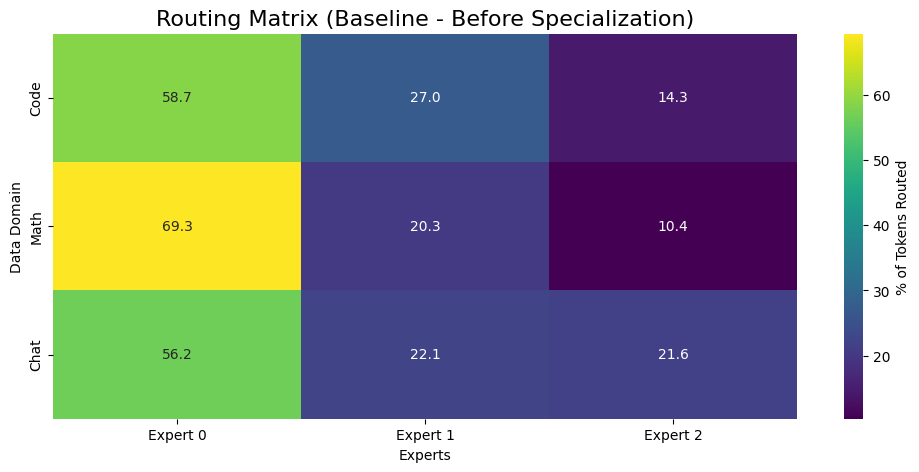


Analyzing routing of the specialized model...
Analyzing routing patterns across the dataset...


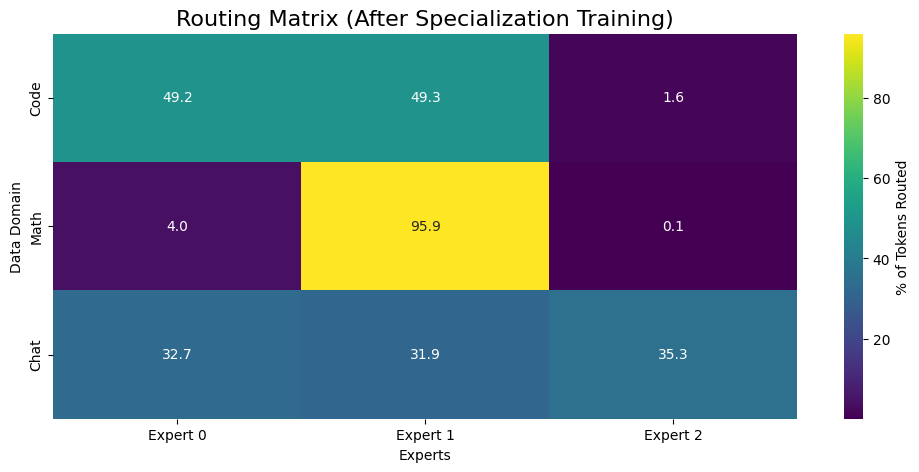

In [ ]:

print("\nAnalyzing routing of the original upcycled model (Baseline)...")
baseline_routing_df = analyze_routing(original_model, specialized_loader, device, config.num_experts)
plot_routing_heatmap(baseline_routing_df, "Routing Matrix (Baseline - Before Specialization)")


print("\nAnalyzing routing of the specialized model...")
specialized_routing_df = analyze_routing(specialized_model, specialized_loader, device, config.num_experts)
plot_routing_heatmap(specialized_routing_df, "Routing Matrix (After Specialization Training)")


- Here we see a clear and successful transformation of the model's internal routing policy. Initially, the model was defaulting to Expert 0 for all domains. After specialization training, we see that Expert 1 has near perfect specialization in maths, and quite an increase in code for Expert 0 and Chat for Expert 2:


In [ ]:

layer_to_inspect = config.num_hidden_layers // 2

example_sentences = [
    # Code examples
    "def fibonacci(n):\n    if n <= 1:\n        return n\n    return fibonacci(n-1) + fibonacci(n-2)",
    "class Stack:\n    def __init__(self):\n        self.items = []\n    def push(self, item):\nself.items.append(item)\n",
    "numbers = [2, 4, 6, 8, 10]\nsquares = [x**2 for x in numbers]\nprint(squares)",

    # Math examples
    "Evaluate the definite integral of sin(x) from 0 to π, which equals 2.",
    "The quadratic formula is given by x = (-b ± sqrt(b^2 - 4ac)) / (2a).",
    "If P(A) = 0.3 and P(B) = 0.5 with A and B independent, then P(A ∩ B) = 0.15.",

    # Chat examples
    "Can you recommend a good sci-fi movie to watch on the weekend?",
    "I’m planning a trip to Kenya, what are the must-see places?",
    "What’s the difference between cold brew coffee and iced coffee?",

]


# Run the analysis for each sentence
for sentence in example_sentences:
    routing_df = analyze_sentence_routing(sentence, specialized_model, tokenizer, device, layer_to_inspect)
    visualize_routing(routing_df, sentence)

## Here we see tokens like `"(", ")", "=", "**"` etc routed correctly to maths expert, and we see tokens like `"class", "return", "def"` etc routed to code expert.

### We even get better results when we continue training.

## Training for even longer

In [ ]:
trained_model = train_specialized_model(
    specialized_model,
    specialized_loader,
    device,
    spec_config,
    ROUTER_WARM_START_STEPS=600,
    JOINT_TUNING_STEPS=400,
    GUIDANCE_COEF=20.0
)


--- Configuring for Stage A: Router Warm-start ---
Freezing all parameters EXCEPT MoE router gates.
Stage 'A': 79,678,080 / 322,130,880 parameters are trainable.

--- Starting Specialized Training with Aggressive Strategy ---
Step 50/1000 | Stage: A (Router Only) | Total Loss: 21.866 | LM Loss: 1.335 | Guidance Loss: 1.026570 | Time: 41.4s
Step 100/1000 | Stage: A (Router Only) | Total Loss: 16.082 | LM Loss: 0.496 | Guidance Loss: 0.779278 | Time: 33.7s
Step 150/1000 | Stage: A (Router Only) | Total Loss: 23.657 | LM Loss: 0.997 | Guidance Loss: 1.133016 | Time: 33.2s
Step 200/1000 | Stage: A (Router Only) | Total Loss: 16.176 | LM Loss: 1.703 | Guidance Loss: 0.723612 | Time: 33.8s
Step 250/1000 | Stage: A (Router Only) | Total Loss: 20.341 | LM Loss: 1.119 | Guidance Loss: 0.961130 | Time: 33.5s
Step 300/1000 | Stage: A (Router Only) | Total Loss: 19.011 | LM Loss: 1.200 | Guidance Loss: 0.890541 | Time: 33.5s
Step 350/1000 | Stage: A (Router Only) | Total Loss: 17.006 | LM Loss: 1.


Analyzing routing of the original upcycled model (Baseline)...
Analyzing routing patterns across the dataset...


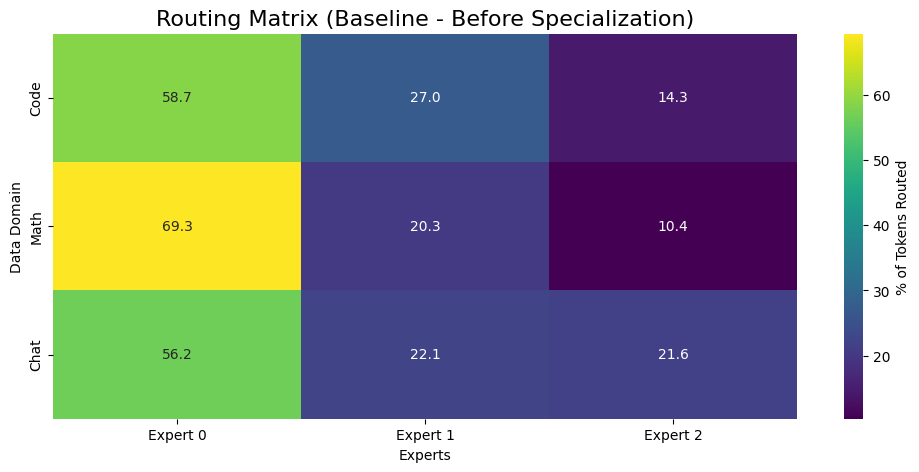


Analyzing routing of the specialized model...
Analyzing routing patterns across the dataset...


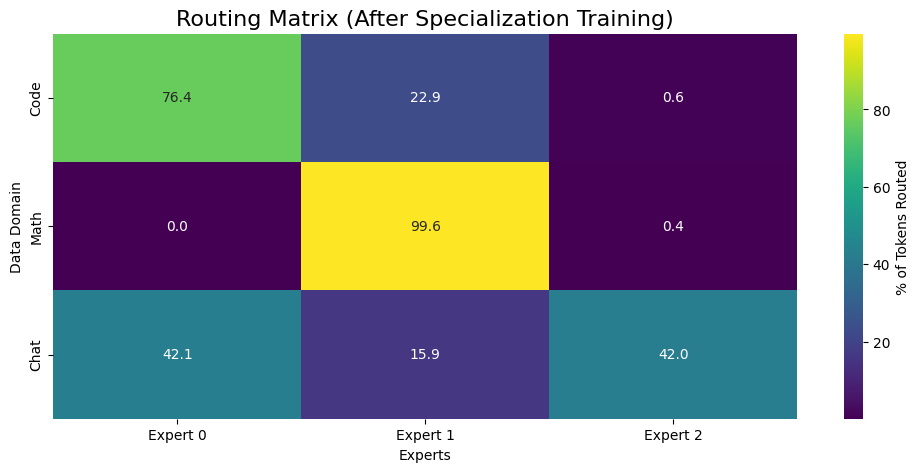

In [ ]:

print("\nAnalyzing routing of the original upcycled model (Baseline)...")
baseline_routing_df = analyze_routing(original_model, specialized_loader, device, config.num_experts)
plot_routing_heatmap(baseline_routing_df, "Routing Matrix (Baseline - Before Specialization)")


print("\nAnalyzing routing of the specialized model...")
specialized_routing_df = analyze_routing(specialized_model, specialized_loader, device, config.num_experts)
plot_routing_heatmap(specialized_routing_df, "Routing Matrix (After Specialization Training)")


In [ ]:

layer_to_inspect = config.num_hidden_layers // 2

example_sentences = [
    # Code examples
    "def fibonacci(n):\n    if n <= 1:\n        return n\n    return fibonacci(n-1) + fibonacci(n-2)",
    "class Stack:\n    def __init__(self):\n        self.items = []\n    def push(self, item):\nself.items.append(item)\n",
    "numbers = [2, 4, 6, 8, 10]\nsquares = [x**2 for x in numbers]\nprint(squares)",

    # Math examples
    "Evaluate the definite integral of sin(x) from 0 to π, which equals 2.",
    "The quadratic formula is given by x = (-b ± sqrt(b^2 - 4ac)) / (2a).",
    "If P(A) = 0.3 and P(B) = 0.5 with A and B independent, then P(A ∩ B) = 0.15.",

    # Chat examples
    "Can you recommend a good sci-fi movie to watch on the weekend?",
    "I’m planning a trip to Kenya, what are the must-see places?",
    "What’s the difference between cold brew coffee and iced coffee?",

]


# Run the analysis for each sentence
for sentence in example_sentences:
    routing_df = analyze_sentence_routing(sentence, specialized_model, tokenizer, device, layer_to_inspect)
    visualize_routing(routing_df, sentence)